# Q3 – Tag-based Recommendation Visualizations

This notebook explores the results of **Q3**:

> *Which movies are recommended based on the tags of the films the user has watched?*

We assume you have a CSV file with at least the columns:

- `user_id`
- `rank` (1 = best recommendation)
- `score` (tag-based similarity / relevance score)
- `movie_id`
- `movie_title`
- `release_year`

The notebook will produce:

1. A **heatmap** of scores by user and rank.
2. A **per-user bar chart** of top-10 tag-based recommendations.
3. **Release year vs score** plots to see temporal bias (new vs old movies).
4. (Optional) **Q1 vs Q4 comparison** for a selected user, if you also load the Q1 CSV.


## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline


## 2. Load Q4 recommendation data

Set `q4_path` to the location of your Q4 CSV. It must contain at least
`user_id, rank, score, movie_id, movie_title, release_year`.


In [2]:
q4_path = Path('../data/q4_results.csv')  
q1_path = Path('../data/q1_user_recommendations.csv')
q4 = pd.read_csv(q4_path)
q1 = pd.read_csv(q1_path)

required_cols = {'user_id', 'rank', 'score', 'movie_id'}
if not required_cols.issubset(q4.columns):
    raise ValueError(f'Q4 CSV must contain at least {required_cols}, got: {q4.columns.tolist()}')

has_title = 'movie_title' in q4.columns
has_year = 'release_year' in q4.columns
print('Rows:', len(q4))
print('Users:', q4['user_id'].nunique())

Rows: 10000
Users: 1000


In [3]:
import pandas as pd
from pathlib import Path

movies_path = Path('../data/ml-25m-normalized/movies.csv')
movies = pd.read_csv(movies_path)

# Try both common schemas: (movie_id, title) or (movieId, title)
if {'movie_id', 'title'}.issubset(movies.columns):
    movies_sub = movies[['movie_id', 'title']]
    q1 = q1.merge(
        movies_sub,
        left_on='candidate_movie_id',   # Q1 column with IDs
        right_on='movie_id',
        how='left'
    )
elif {'movieId', 'title'}.issubset(movies.columns):
    movies_sub = movies[['movieId', 'title']]
    q1 = q1.merge(
        movies_sub,
        left_on='candidate_movie_id',
        right_on='movieId',
        how='left'
    )
else:
    raise ValueError(f"Unexpected columns in movies.csv: {movies.columns.tolist()}")

# Create a clean label column for plotting
q1['movie_label'] = q1['title'].fillna(q1['candidate_movie_id'].astype(str))

q1.head()


,user_id,candidate_movie_id,score,rank,movieId,title,movie_label
0,1,380.0,0.144162,1,380.0,True Lies,True Lies
1,1,356.0,0.067154,2,356.0,Forrest Gump,Forrest Gump
2,1,593.0,0.054594,3,593.0,"Silence of the Lambs, The","Silence of the Lambs, The"
3,1,590.0,0.033524,4,590.0,Dances with Wolves,Dances with Wolves
4,1,608.0,0.032997,5,608.0,Fargo,Fargo


## 3. Heatmap of Q4 scores by user and rank

This heatmap shows, for a subset of users, the tag-based recommendation scores
for ranks 1–10. Brighter colors mean higher tag similarity.


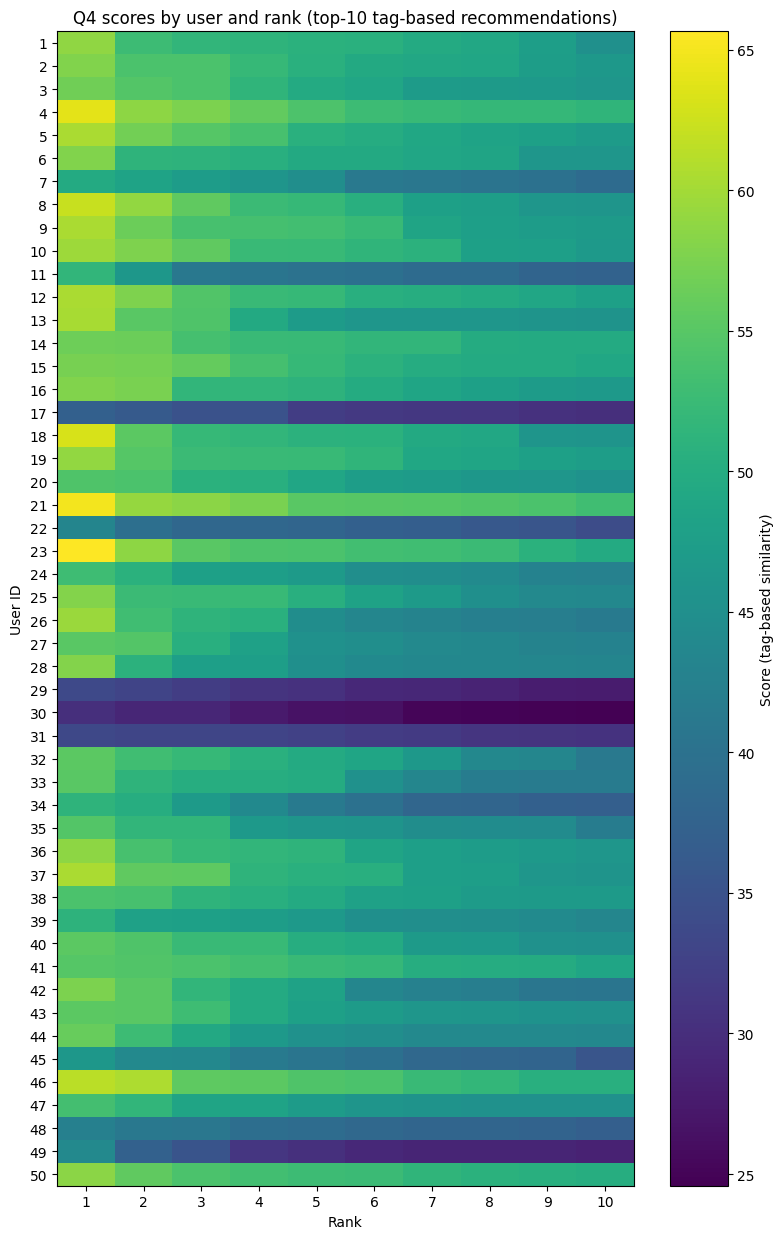

In [4]:
# Number of users to include in the heatmap
N_USERS = 50

users = q4['user_id'].drop_duplicates().sort_values().head(N_USERS)
q4_subset = q4[q4['user_id'].isin(users) & (q4['rank'] <= 10)].copy()

pivot = q4_subset.pivot_table(index='user_id', columns='rank', values='score')

plt.figure(figsize=(8, max(4, len(pivot.index) * 0.25)))
im = plt.imshow(pivot.values, aspect='auto')
plt.colorbar(im, label='Score (tag-based similarity)')
plt.xticks(ticks=np.arange(pivot.shape[1]), labels=pivot.columns)
plt.yticks(ticks=np.arange(len(pivot.index)), labels=pivot.index)
plt.xlabel('Rank')
plt.ylabel('User ID')
plt.title('Q4 scores by user and rank (top-10 tag-based recommendations)')
plt.tight_layout()
plt.show()

## 4. Per-user bar chart of top-10 tag-based recommendations

Set `TARGET_USER_ID` to the user you want to inspect. The chart shows the
top-10 tag-based recommendations for that user.


TARGET_USER_ID = 1


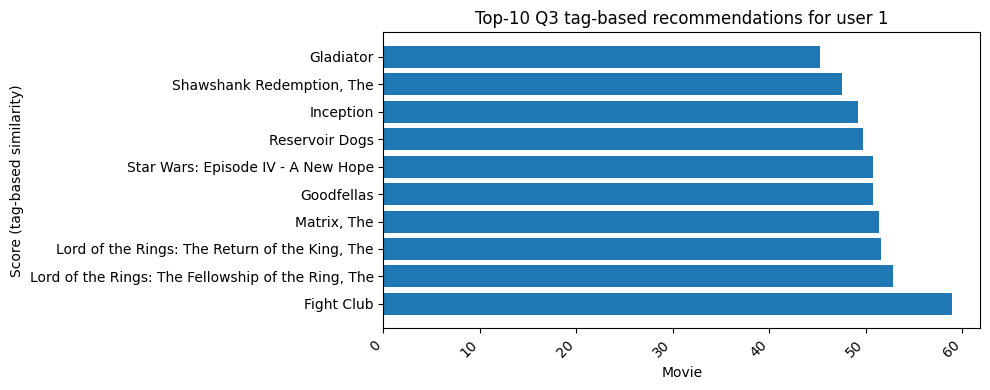

,rank,movie_id,movie_title,score
0,1,2959,Fight Club,58.882248
1,2,4993,"Lord of the Rings: The Fellowship of the Ring,...",52.804240
2,3,7153,"Lord of the Rings: The Return of the King, The",51.584003
3,4,2571,"Matrix, The",51.337498
4,5,1213,Goodfellas,50.753006
5,6,260,Star Wars: Episode IV - A New Hope,50.692253
6,7,1089,Reservoir Dogs,49.729500
7,8,79132,Inception,49.218254
8,9,318,"Shawshank Redemption, The",47.572247
9,10,3578,Gladiator,45.241993


In [5]:
# Choose a user to inspect (default: first user in the heatmap subset)
TARGET_USER_ID = users.iloc[0]
print('TARGET_USER_ID =', TARGET_USER_ID)

user_q4 = q4[q4['user_id'] == TARGET_USER_ID].copy()
user_q4 = user_q4[user_q4['rank'] <= 10].sort_values('rank')

if has_title:
    labels = user_q4['movie_title']
else:
    labels = user_q4['movie_id'].astype(str)

plt.figure(figsize=(10, 4))
plt.barh(labels, user_q4['score'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Score (tag-based similarity)')
plt.xlabel('Movie')
plt.title(f'Top-10 Q3 tag-based recommendations for user {TARGET_USER_ID}')
plt.tight_layout()
plt.show()

user_q4[['rank', 'movie_id'] + ([ 'movie_title'] if has_title else []) + ['score']]

## 5. Release year vs score (Q4)

If `release_year` is present, this section shows how scores vs. release year
are distributed for Q4 top-10 recommendations.


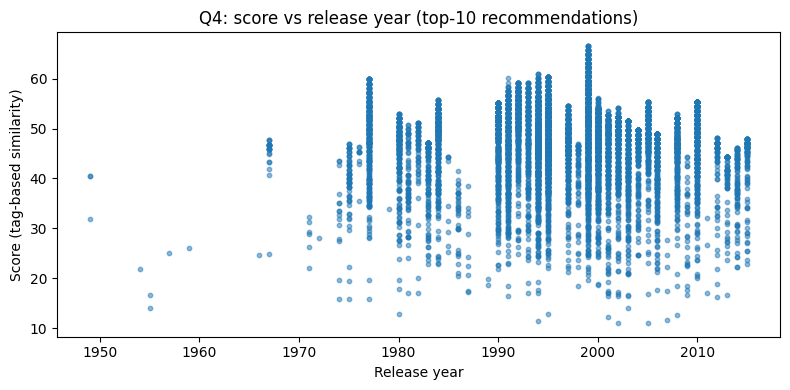

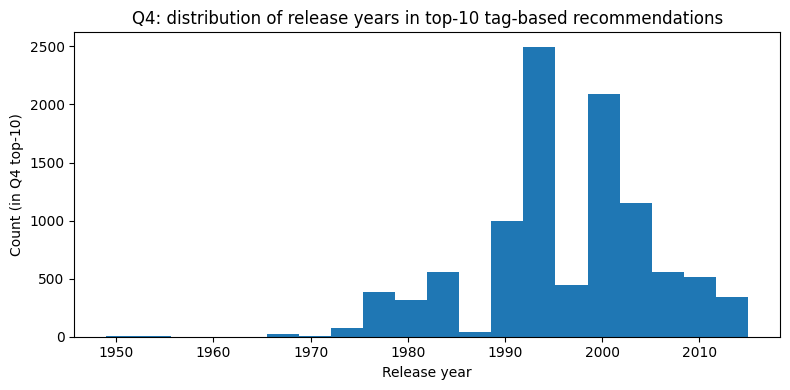

In [6]:
if not has_year:
    print('No release_year column found in Q4 data; skipping this section.')
else:
    q4_year = q4[q4['rank'] <= 10].dropna(subset=['release_year']).copy()

    plt.figure(figsize=(8, 4))
    plt.scatter(q4_year['release_year'], q4_year['score'], s=10, alpha=0.5)
    plt.xlabel('Release year')
    plt.ylabel('Score (tag-based similarity)')
    plt.title('Q4: score vs release year (top-10 recommendations)')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.hist(q4_year['release_year'], bins=20)
    plt.xlabel('Release year')
    plt.ylabel('Count (in Q4 top-10)')
    plt.title('Q4: distribution of release years in top-10 tag-based recommendations')
    plt.tight_layout()
    plt.show()

## 6. Globally most common rank-1 tag-based recommendations

This chart shows which movies most often appear as the **rank-1** tag-based
recommendation across all users.


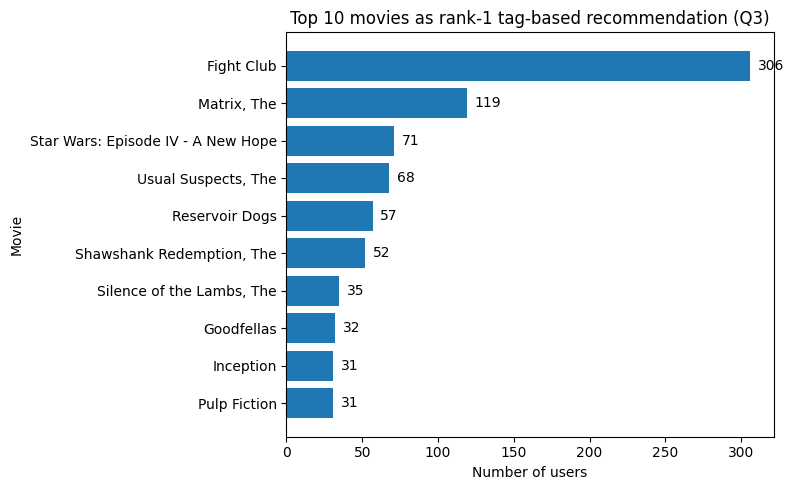

,movie_id,movie_title,n_users
4,296,Pulp Fiction,31
35,79132,Inception,31
13,1213,Goodfellas,32
10,593,"Silence of the Lambs, The",35
5,318,"Shawshank Redemption, The",52
11,1089,Reservoir Dogs,57
1,50,"Usual Suspects, The",68
3,260,Star Wars: Episode IV - A New Hope,71
16,2571,"Matrix, The",119
17,2959,Fight Club,306


In [7]:
TOP_N = 10

q4_rank1 = q4[q4['rank'] == 1].copy()

group_cols = ['movie_id'] + (['movie_title'] if has_title else [])

movie_counts_rank1 = (
    q4_rank1
    .groupby(group_cols)['user_id']
    .nunique()
    .reset_index(name='n_users')
)

movie_counts_rank1 = movie_counts_rank1.sort_values('n_users', ascending=True).tail(TOP_N)

labels = movie_counts_rank1['movie_title'] if has_title else movie_counts_rank1['movie_id'].astype(str)

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(labels, movie_counts_rank1['n_users'])
for i, val in enumerate(movie_counts_rank1['n_users']):
    ax.text(val + 5, i, f'{val:,}', va='center')

ax.set_xlabel('Number of users')
ax.set_ylabel('Movie')
ax.set_title(f'Top {TOP_N} movies as rank-1 tag-based recommendation (Q3)')
plt.tight_layout()
plt.show()

movie_counts_rank1

## 7. Optional: Q1 vs Q4 comparison for a selected user

If you also have the Q1 next-movie recommendations in a CSV
(`q1_recommendations.csv`), you can uncomment the cell below to compare
Q1 vs Q4 for the same user.


Comparison for user: 100


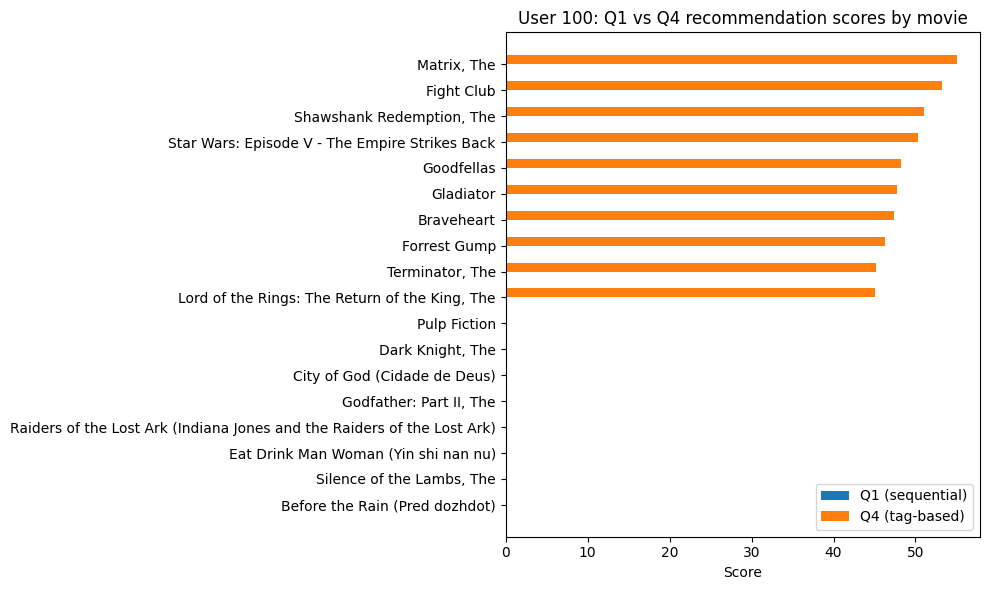

,movie,Q1,Q4
0,Before the Rain (Pred dozhdot),0.016599,0.000000
15,"Silence of the Lambs, The",0.017026,0.000000
4,Eat Drink Man Woman (Yin shi nan nu),0.017739,0.000000
13,Raiders of the Lost Ark (Indiana Jones and the...,0.018294,0.000000
8,"Godfather: Part II, The",0.018761,0.000000
2,City of God (Cidade de Deus),0.019320,0.000000
3,"Dark Knight, The",0.020483,0.000000
12,Pulp Fiction,0.030808,0.000000
10,"Lord of the Rings: The Return of the King, The",0.000000,45.109753
17,"Terminator, The",0.000000,45.198498


In [8]:
import numpy as np
import matplotlib.pyplot as plt

COMP_USER_ID = 100  # pick the user you want to analyse
print("Comparison for user:", COMP_USER_ID)

q1_user = q1[(q1["user_id"] == COMP_USER_ID) & (q1["rank"] <= 10)].copy().sort_values("rank")
q4_user = q4[(q4["user_id"] == COMP_USER_ID) & (q4["rank"] <= 10)].copy().sort_values("rank")

# Labels
q1_user_label_col = 'movie_label'  # we just created this
q4_user_label_col = 'movie_title' if 'movie_title' in q4_user.columns else 'movie_id'

# Build union of movies
m_q1 = q1_user[[q1_user_label_col, "score"]].rename(
    columns={q1_user_label_col: "movie", "score": "Q1"}
)
m_q4 = q4_user[[q4_user_label_col, "score"]].rename(
    columns={q4_user_label_col: "movie", "score": "Q4"}
)

merged = pd.merge(m_q1, m_q4, on="movie", how="outer").fillna(0)

# Sort by max score so most relevant movies are near the top
merged["max_score"] = merged[["Q1", "Q4"]].max(axis=1)
merged = merged.sort_values("max_score", ascending=True)  # small at bottom for barh

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

y = np.arange(len(merged))
h = 0.35

ax.barh(y - h/2, merged["Q1"], height=h, label="Q1 (sequential)")
ax.barh(y + h/2, merged["Q4"], height=h, label="Q4 (tag-based)")

ax.set_yticks(y)
ax.set_yticklabels(merged["movie"])
ax.set_xlabel("Score")
ax.set_title(f"User {COMP_USER_ID}: Q1 vs Q4 recommendation scores by movie")
ax.legend(loc="lower right")

plt.tight_layout()
plt.show()

merged[["movie", "Q1", "Q4"]]
